<Axes: >

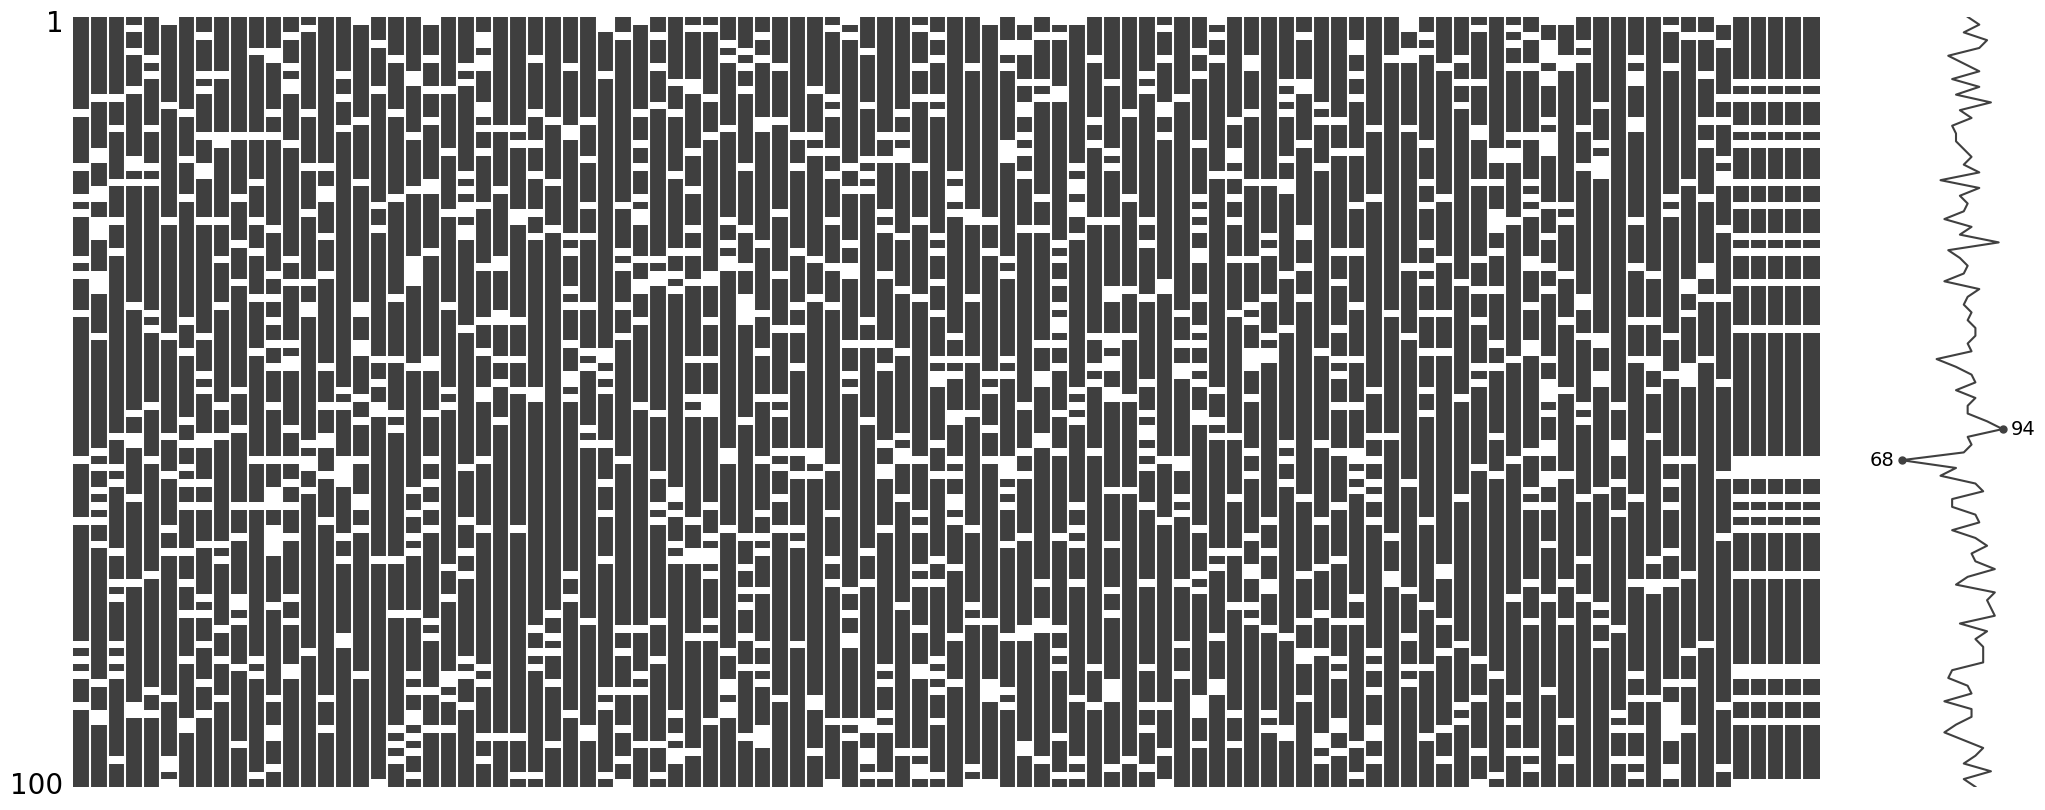

In [1]:
import pandas as pd
import missingno as msno

df = pd.read_csv('case1Data.csv')
y = df['y']
X = df.drop('y', axis=1)

msno.matrix(X) #visualize missing data


<Axes: >

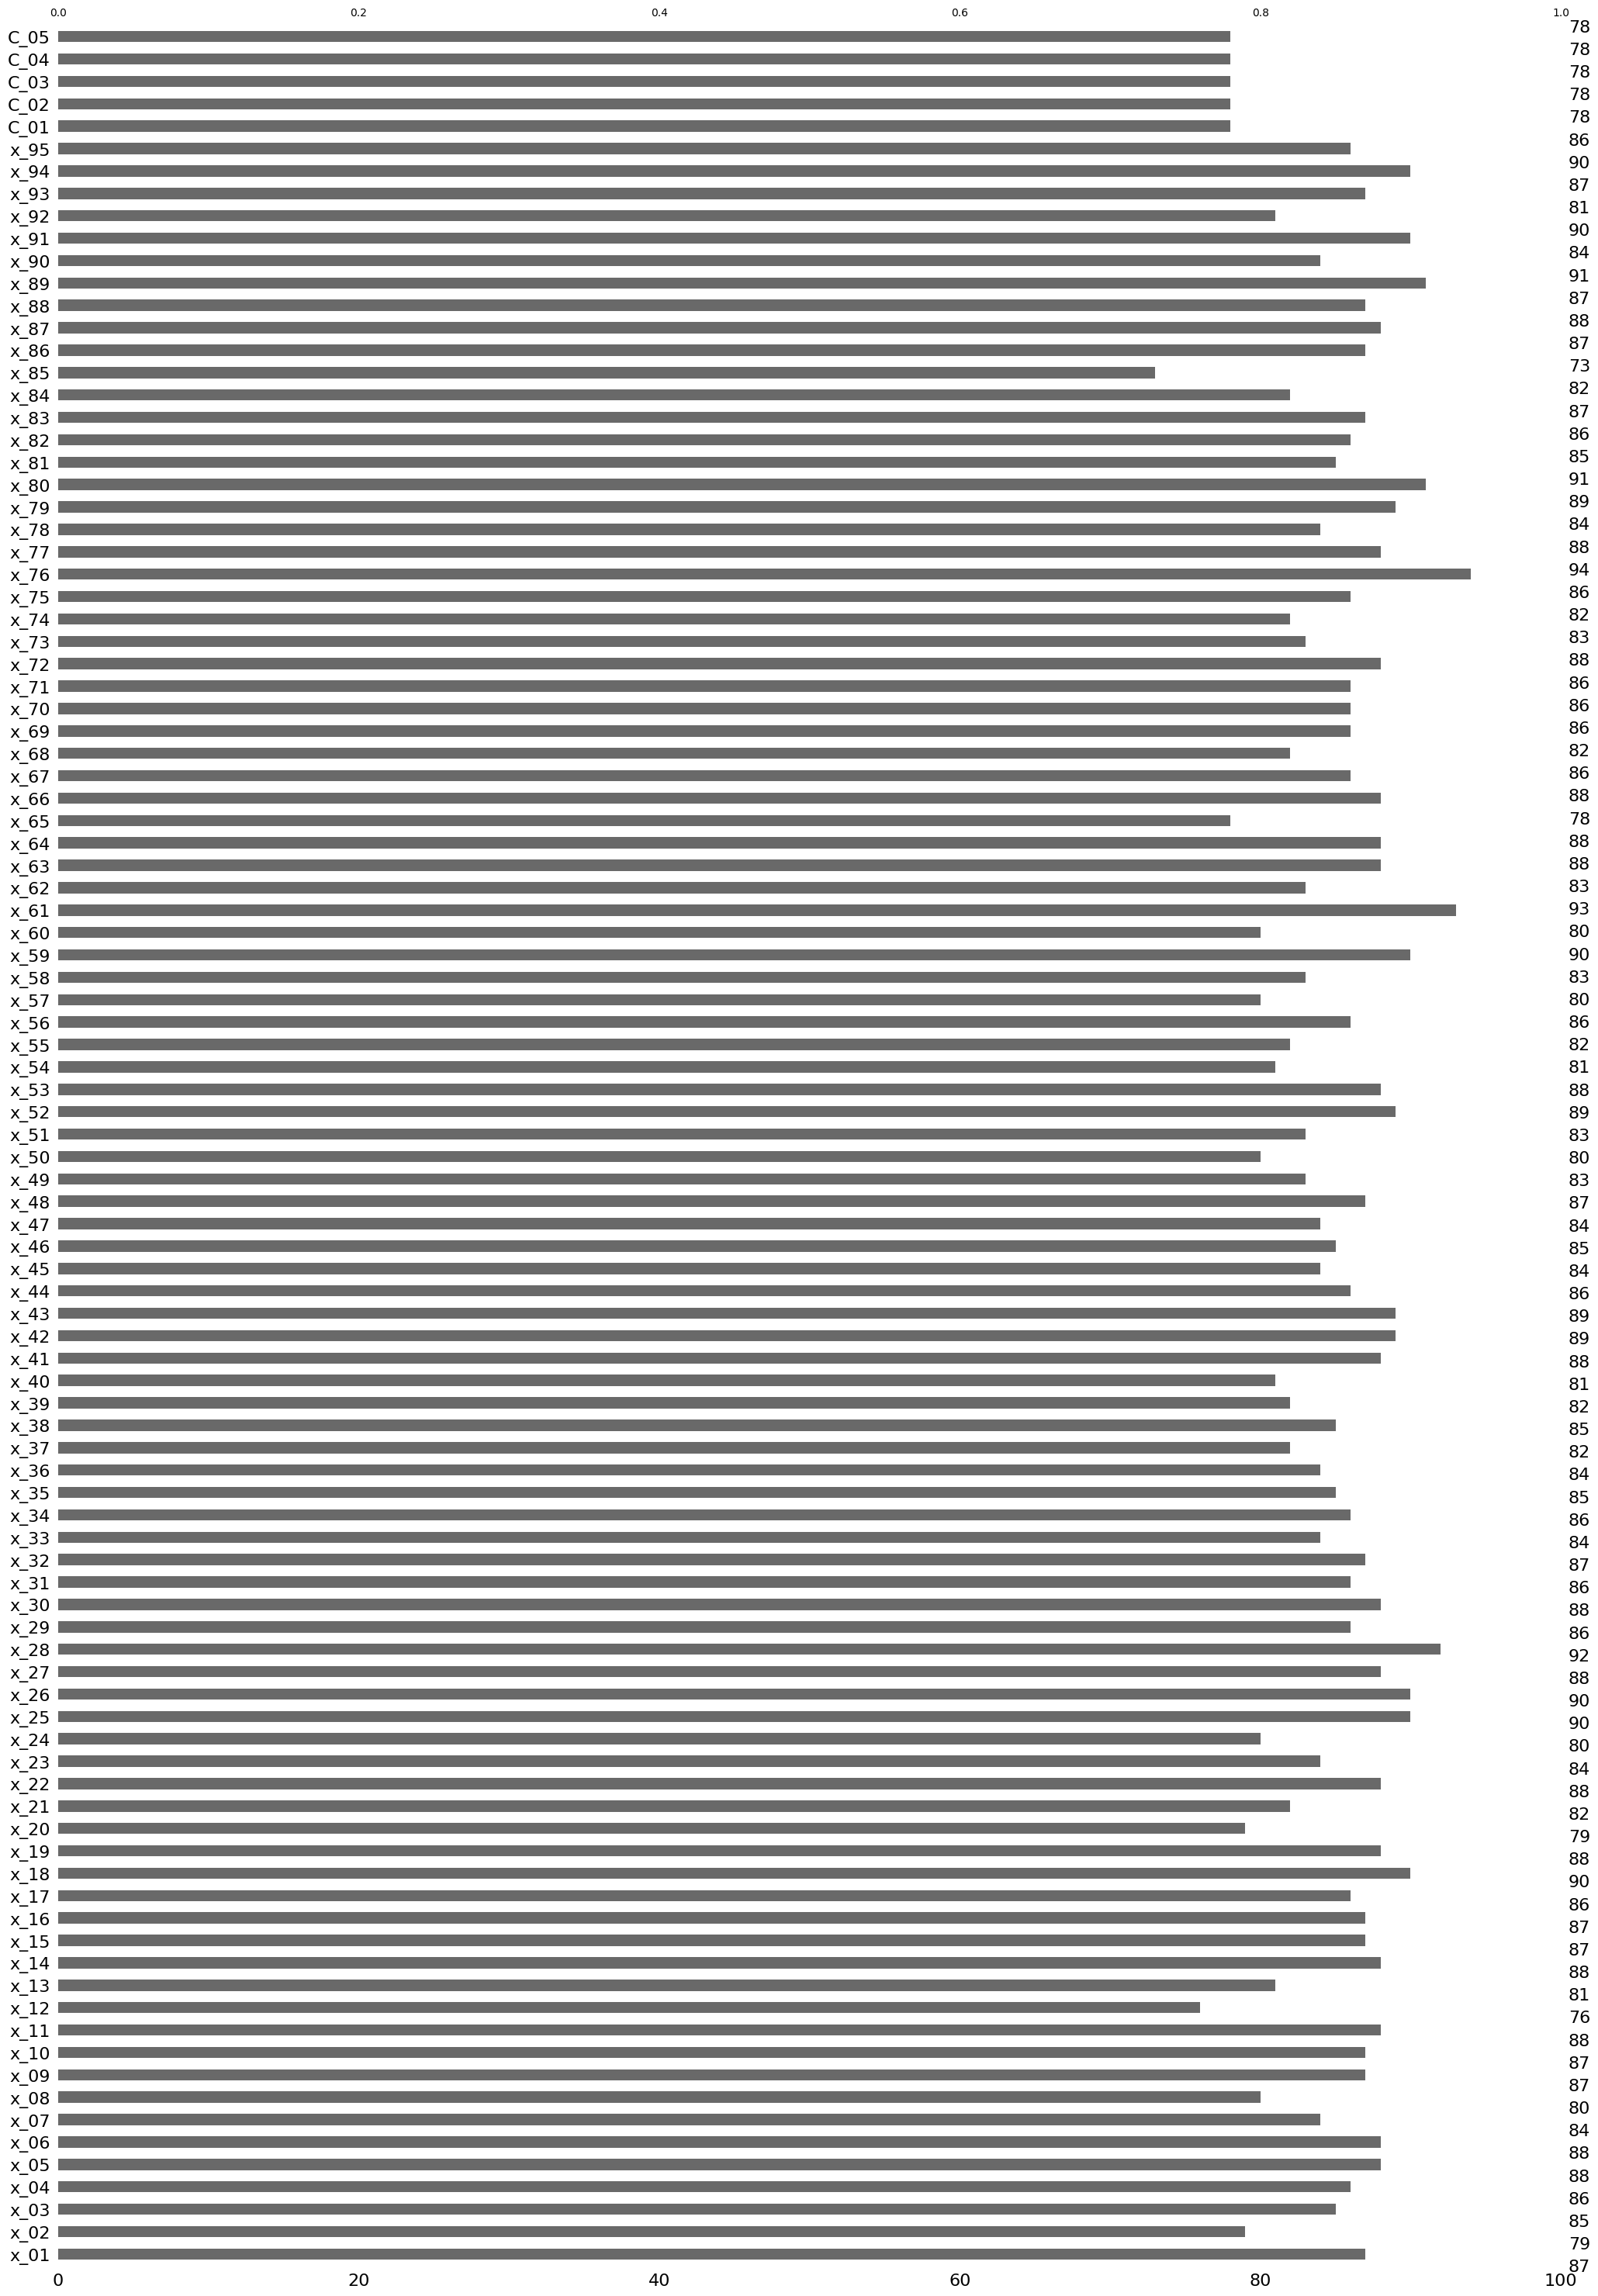

In [2]:
msno.bar(X) # how many missing values in each column

<Axes: >

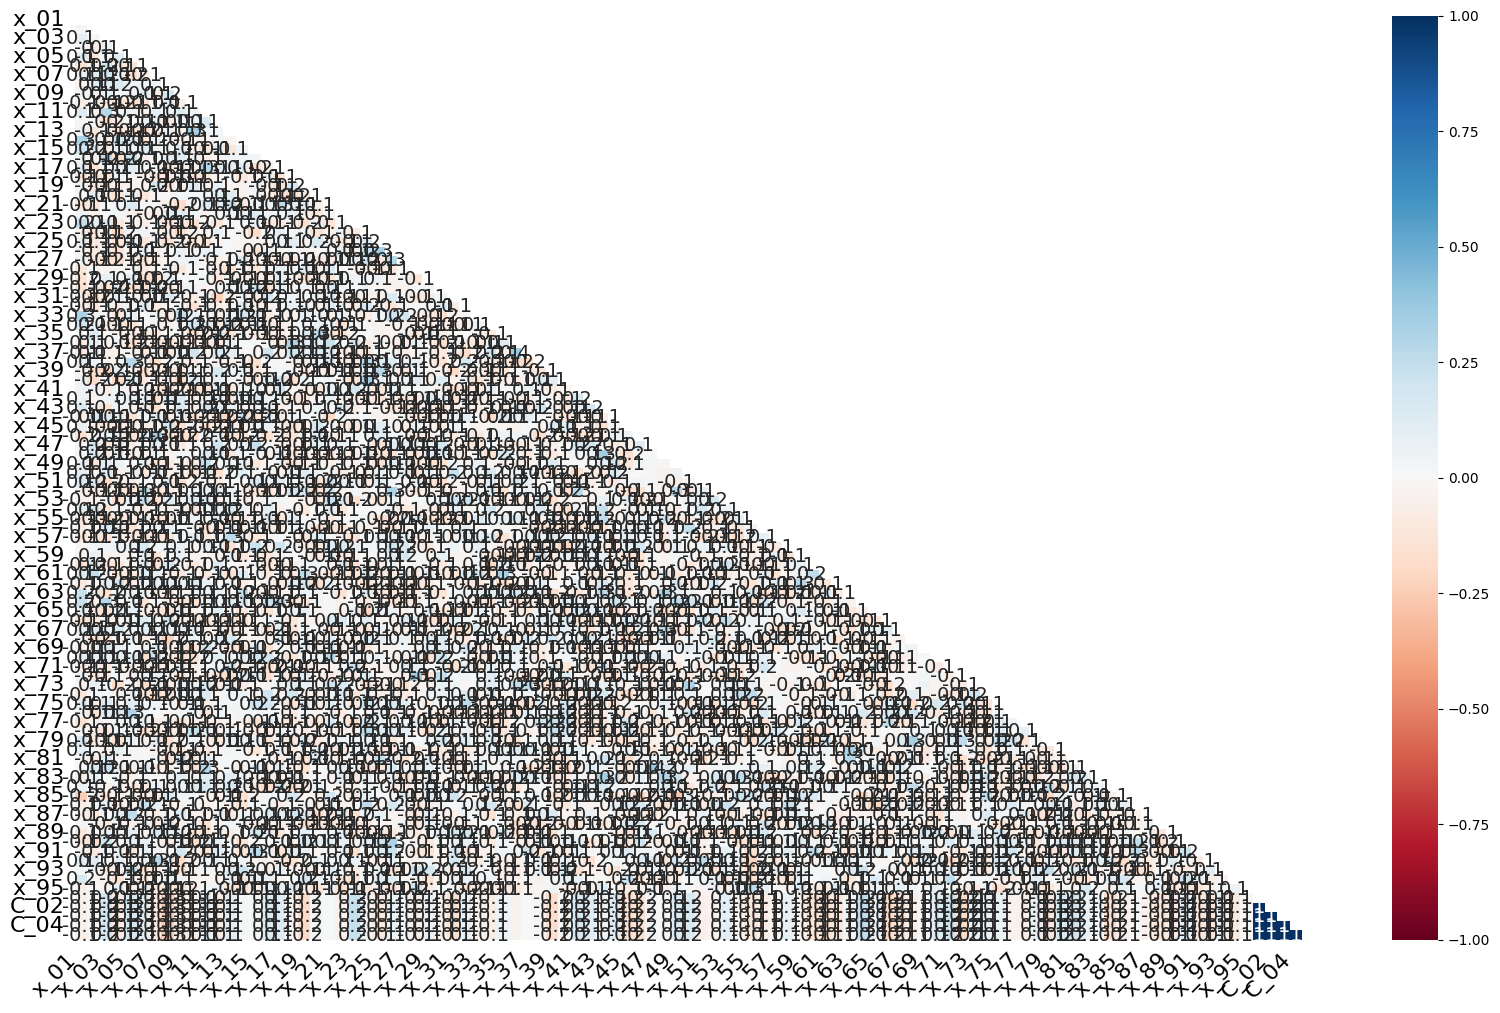

In [3]:
msno.heatmap(X)

In [7]:
corr_matrix = X.isnull().astype(int).corr() #correlation matrix of missing values

#count values > 0.7 in corr_matrix
#[print(corr_matrix.iloc[i,j]) for i in range(len(corr_matrix)) for j in range(i) if abs(corr_matrix.iloc[i,j]) > 0.9]

print('correlated missing values:')
[print(i,j) for i in range(len(corr_matrix)) for j in range(i) if abs(corr_matrix.iloc[i,j]) > 0.9]

correlated missing values:
96 95
97 95
97 96
98 95
98 96
98 97
99 95
99 96
99 97
99 98


[None, None, None, None, None, None, None, None, None, None]

In [21]:
correlated_missing_values_indicator = X.iloc[:,-5:].isnull().astype(int)
corr_y_with_missing_values_indicator = correlated_missing_values_indicator.corrwith(y)
print(f'missingness indicator variables correlation with y: \n {corr_y_with_missing_values_indicator}')

missingness indicator variables correlation with y: 
 C_01    0.187
C_02    0.187
C_03    0.187
C_04    0.187
C_05    0.187
dtype: float64


In [42]:
correlated_missing_values = X.iloc[:,-5:]
corr_cfeatures = correlated_missing_values.corr(method='spearman')
print(f'pairwise correlation between C features: \n {corr_cfeatures}')

pairwise correlation between C features: 
           C_01  C_02      C_03      C_04      C_05
C_01  1.000000   NaN -0.079865  0.131895 -0.045511
C_02       NaN   NaN       NaN       NaN       NaN
C_03 -0.079865   NaN  1.000000 -0.094620  0.183680
C_04  0.131895   NaN -0.094620  1.000000  0.021288
C_05 -0.045511   NaN  0.183680  0.021288  1.000000


In [20]:
correlated_missing_values = X.iloc[:,-5:]
corr_y_with_missing_values = correlated_missing_values.corrwith(y)
print(f'the last 5 features correlation with y: \n {corr_y_with_missing_values}')

the last 5 features correlation with y: 
 C_01    0.065338
C_02         NaN
C_03    0.128153
C_04    0.048144
C_05   -0.092239
dtype: float64


In [51]:
corr_y = X.corrwith(y) # pearson correlation (linear relationship)
#print(corr_y)

print(corr_y[f'{corr_y.idxmax()}'])
print(corr_y[f'{corr_y.idxmin()}'])

# count values between -0.5 and 0.5
print(len(corr_y[abs(corr_y) < 0.2]))



0.7703028401132819
-0.26746784616402386
59


In [52]:
corr_y = X.corrwith(y, method='spearman') # spearman: rank (not necessarily linear relationship)
#print(corr_y)

print(corr_y[f'{corr_y.idxmax()}'])
print(corr_y[f'{corr_y.idxmin()}'])

# count values between -0.5 and 0.5
print(len(corr_y[abs(corr_y) < 0.2]))

0.7783225195013486
-0.28134839007598333
64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [ ]:
# checking multual information between the features and y

from sklearn.feature_selection import mutual_info_regression

X_imputed = X.fillna(X.mean())
# Compute mutual information between each feature and the target
mi_scores = mutual_info_regression(X_imputed, y, discrete_features=False)

# Combine results into a nice DataFrame
mi_results = pd.DataFrame({
    'feature': X_imputed.columns,
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)

print(f'max: \n{mi_results.max()}')
print(f'number of MI > 0.1: \n{len(mi_results[mi_results["mi_score"] > 0.1])}')
print(f'number of MI = 0 : \n{len(mi_results[mi_results["mi_score"] == 0])}')


max: 
feature         x_95
mi_score    0.299664
dtype: object
number of MI > 0.1: 
12
number of MI = 0 : 
50


Findings:
* 5 of the features share the exact same missing pattern, but none of them correlate strongly with y or the other features 
* The overall correlation among features is low (pearson and spearman)
* 50 features have no individual relationship with the target sice MI = 0

Idea: 
* the 5 features are "missing completely at random" --> can use simple imputation methods since more complex methods rely on correlations or predictive relationshipps among features or with y
    * mean: preserves mean but reduces variance
    * median: more robust if outliers exist or skew
* keep the 5 features since the fraction of missing is not that big
* Compare performance between a model trained on all features and a model trained on 1. features with MI > 0, 2. fetures with corr > 0.2 
* perform PCA and fit the model using the first few principal components (assuming many redundant features)
* add missingness indicators to the data such that the model can learn from them

Notes:
* Since we have #features = #observations, its easy to overfit, so we might want to choose a regularized regression method: ridge, lasso, elastic net
* Only use KNN if there's evidence of non-linear relationships
* Can use OLS as the baseline method

Questions:
* How do we estimate RMSE???